# Carnegie Mellon Data Science Club : Practical Natural Language Processing

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: This notebook contains an introduction to document analysis with OkCupid data. It is designed to be used at a workshop for introducing individuals to natural language processing._

## Some Initial Setup

_(Note: If you are using this notebook locally, you can likely skip this step. This step is primarily intended for individuals who want to skip installing all features and want to immediately work on this notebook in the cloud.)_

Before we get started, we have a couple things to set up in case you would like to follow along without many installations.

1. I am using the **IBM Data Science Experience**, a platform used for collaborating on data analyses across an organization. We can visit the data science experience here: http://datascience.ibm.com

2. Set up an account by clicking "Sign Up" and moving through the workflow.

3. Once you are logged in, click the **Object Storage** section to provide available containers for loading in data assets.

4. Go to **My Projects** and click on the **create project** section to initialize a new project. Give your project a name and a description. We will be using ```python``` 2 for this workshop. The ```spark``` version does not really matter, since we will not be using ```spark``` actively. Give your data asset container a name.

5. You will now be within your new project dashboard. You can start a new notebook by clicking the **add notebook** button. We will be using ```python``` 2 for this workshop, as discussed before.

Also, to clear up potential warnings that we aren't too concerned with in this context, run the following lines of code:

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Introduction: What Is Natural Language Processing?

"Natural Language Processing", or NLP for the sake of having an acronym, is the combination of two subphrases. 

* "Natural Language" refers to a system of communication that has been crafted over the centuries by cultures, faiths, nations, and empires. This term is meant to differentiate it from a language that has been artificially crafted by one community (for example, ```python```).

* "Language Processing" refers to the methods and technologies developed to encode language, edit language, and interpret language. In artificial languages such as ```Java```, processing the language can be translating a script into bytecode for compilation. In natural languages, this could be a translation method such as the Rosetta Stone.

Together, "Natural Language Processing" refers to the methods and technologies used to infer properties and components of languages in the spoken and written word. Some of these methods include:

* Translating a sentence from English to French.

* Having a personal assistant respond to your spoken phrases.

* Having an artificial intelligence find the logical implications of a written statement found to be true.

Today, we will be working on a simpler method: using the language of a writer to predict the age of that writer.

## A note for 15-112 Students

In Fundamentals of Programming and Computer Science (15-112), you are taught a way of writing ```python``` (and code in general) for the purpose of writing software. In industry, there are many reasons for writing code, and you may come across instances where you are not writing code specifically meant for the next iPhone app.

In this notebook, I will show you the ways of structuring code in a way that is designed for data analysis and model selection. Thus, there will be some coding practices that are somewhat different - and potentially discourage - in the 15-112 curriculum. In particular, the use of global variables is considered rather standard in the practice of data mining.

I would like you to be aware that some of these practices in this notebook may need adaptation before leveraged in your 15-112 projects. Most of all, remember to stay within style rules of a course when practicing data science.

<a id="metadataAnalysis" />

## Metadata Analysis

Before beginning to explore a dataset for prediction and analysis, it is essential that you study how the data is generated in order to inform your exploration.

Our dataset is a set of dating profiles from [OkCupid](https://www.okcupid.com), a dating website that targets young adults in a way that parallels dating websites such as [Match.com](match.com) and [eHarmony](eharmony.com). The data was transcribed from a web scrape and presented [as a dataset designed for introductory statistics and data science courses](https://github.com/rudeboybert/JSE_OkCupid).

This dataset has many features, but according to the [documentation](data/JSE_OkCupid/okcupid_codebook.txt), the ```essay``` variables contain all language data inputted by users of OkCupid and the ```age``` variable contains the age of the user. For the sake of simplification in our analysis, we will limit our analysis the **self-summary** variable (```essay0```) and the **age** variable (```age```).

Things that we should note:

* This dataset comes from web scrape, and while transcribed to some degree into a data frame by the data collectors, it is likely to be filled with many assets from the web.

* This dataset is primarily user-inputted. This may mean that we will see spelling mistakes related to human error, and that we will see a vocabulary created by the users rather than by the platform owner (OkCupid).

## Scanning a document

Let us start by loading in the dataset of profiles. This is a ```.csv``` file, which stands for Comma-Separated Values. If we take a look at the [text representation of the dataset](data/JSE_OkCupid/profiles.csv), we see that there is a set of column keys in the first row of the ```.csv``` file, and each row below it refers to a filled-in observation of the dataset. In this context, a "filled-in observation" is a transcribed OkCupid profile.

Typically, we can load in a ```.csv``` file using the ```csv``` package available in base ```Python```. However, for the sake of having a more elegant coding process, I generally use the ```pandas``` package to manipulative large dataframes. You can refer to the [reference materials](#refMaterials) for instructions on how to install ```pandas```.

In [2]:
import pandas as pd

In [3]:
okCupidFrame = pd.read_csv("data/JSE_OkCupid/profiles.csv")

Let us take a look at the dimension of this data frame. This is held in the ```shape``` attribute of the dataframe.

In [4]:
numRows = okCupidFrame.shape[0]
numCols = okCupidFrame.shape[1]
print "Number of Rows:", numRows
print "Number of Columns:", numCols

Number of Rows: 59946
Number of Columns: 31


We see that there are 59946 profile observations in this dataset, which is a sizable amount of profiles to consider. We also see that each profile contains 31 features, many of which were transcribed by the original data collectors. As discussed in the [metadata analysis](#metadataAnalysis), the language-oriented features are found in the ```essay``` variables. For now, let us consider the self summary variable of the profiles contained in the ```essay0``` variable.

In [5]:
selfSummaries = okCupidFrame["essay0"]

Let us first check to see if there are any missing values in this column. This will be important for when we want to use these summaries for predictive purposes.

In [6]:
#make conditional on which summaries are empty
emptySections = selfSummaries[selfSummaries.isnull()]
numNullEntries = emptySections.shape[0]
print "The number of entries with null self-summaries is", numNullEntries

The number of entries with null self-summaries is 5485


We see that we have 5485 profiles without self-summaries. For the sake of considering only completed profiles up to the summary, we will filter out observations with ```NaN``` entries for ```essay0```.

In [7]:
#get observations with non-null summaries
filteredOkCupidFrame = okCupidFrame[okCupidFrame["essay0"].notnull()]
#then reobtain self summaries
selfSummaries = filteredOkCupidFrame["essay0"]

### Searching and analyzing a single profile

The basis of natural language processing comes simply from analyzing a string. In this extent, it is natural to start out analysis by analyzing a single **document**, which is one observation in a language dataset. In this case, our **document** would be a single self-summary.

In [8]:
consideredSummary = selfSummaries[0]

Since this is a string, we can read it by a simple ```print``` statement.

In [9]:
print consideredSummary

about me:<br />
<br />
i would love to think that i was some some kind of intellectual:
either the dumbest smart guy, or the smartest dumb guy. can't say i
can tell the difference. i love to talk about ideas and concepts. i
forge odd metaphors instead of reciting cliches. like the
simularities between a friend of mine's house and an underwater
salt mine. my favorite word is salt by the way (weird choice i
know). to me most things in life are better as metaphors. i seek to
make myself a little better everyday, in some productively lazy
way. got tired of tying my shoes. considered hiring a five year
old, but would probably have to tie both of our shoes... decided to
only wear leather shoes dress shoes.<br />
<br />
about you:<br />
<br />
you love to have really serious, really deep conversations about
really silly stuff. you have to be willing to snap me out of a
light hearted rant with a kiss. you don't have to be funny, but you
have to be able to make me laugh. you should be able to b

_Figure 1: A self-summary of an individual in our dataset._

We can see a couple of things just from looking at this profile:

* This man sounds extremely pretentious.

* There are some misspellings due to the user-inputted aspects in this self-summary. most notably, the word "simularities" should probably be "similarities."

* Ther are several ```br``` tags within the document that do not add information to our understanding of the document. These tags are primarily for OkCupid to display the self-summary properly on their website.

Thus, before we analyze this dataset, we need to do some data cleansing.

#### Cleaning and searching with Regular Expression (```regex```)

Regular Expression is defined as a sequence of characters that defines a search pattern. This search pattern is used to "find" and "find and replace" certain information in strings through string search algorithms. To give an example, say that I am interested in quantifying the narcissism found in the self-summary above. Perhaps I am interested in the number of times that "i" shows up in the summary. We represent this with the simple regular expression search query that accounts for the letter $i$ and then accounts for all potential punctuation that usually follows a lone $i$:

```[ \.,:;?!\n]i[ \.,:;?!\n$]```

This expression looks for some measure of punctuation, then an $i$ and then looks for a potential followup punctuation to indicate that is a lone $i$. Theses measures of punctuation can be a space, period, comma, colon, semi-colon, question mark, explanation point, or an end-of-line marker (```$```).

In [10]:
import re #regular expression library in base Python
#let us compile this for search
iRe = re.compile("[ \.,:;?!\n]i[ \.,:?!\n]")
#then find all the times it occurs in the summary
iObservanceList = iRe.findall(consideredSummary)
print iObservanceList

['\ni ', ' i ', ' i\n', ' i ', ' i\n', ' i\n', ' i ', ' i ']


In [11]:
numIs = len(iObservanceList)

We see that the speaker refers to himself in terms of "i" 8 times in this self-summary. This is actually more reasonable than most people when referring to themselves, but let's try to extend this regular expression to other self-centered terms. We will now search for

```[ \.,:;?!\n](i|me)[ \.,:?!\n]```

The ```|``` symbol represents an or operator for in a section. In this context, this regular expression is looking for either "i" or "me" followed by some punctuation in order to identify lone observations of ```i``` and ```me``` instead of appendages on other words (for example, ```i``` in ```intellectual``` and ```me``` in ```meandering```).

In [12]:
selfCenteredRe = re.compile("[ \.,:;?!\n](i|me)[ \.,:?!\n]")
#find all observations of this regular expression
selfObsList = selfCenteredRe.findall(consideredSummary)
print selfObsList

['me', 'i', 'i', 'i', 'i', 'i', 'i', 'me', 'i', 'me', 'me', 'me', 'i']


In [13]:
numNarcissisticWords = len(selfObsList)

We see that when we extend our search to include "me" as a possible pattern to recognize, we see that the number of self-referrals increases to 13. We can extend this to other aspects of the self-summary, and potentially more interesting patterns we want to find in the language.

Regular Expressions can also be used to substitute particular components of the summary for data cleaning purposes. For instance, let us alter the mistake of "simularities" as "similarities" in the above summary.

In [14]:
#make the re
simRe = re.compile("simularities")
#then perform a sub
filteredSummary = simRe.sub("similarities",consideredSummary)
print filteredSummary

about me:<br />
<br />
i would love to think that i was some some kind of intellectual:
either the dumbest smart guy, or the smartest dumb guy. can't say i
can tell the difference. i love to talk about ideas and concepts. i
forge odd metaphors instead of reciting cliches. like the
similarities between a friend of mine's house and an underwater
salt mine. my favorite word is salt by the way (weird choice i
know). to me most things in life are better as metaphors. i seek to
make myself a little better everyday, in some productively lazy
way. got tired of tying my shoes. considered hiring a five year
old, but would probably have to tie both of our shoes... decided to
only wear leather shoes dress shoes.<br />
<br />
about you:<br />
<br />
you love to have really serious, really deep conversations about
really silly stuff. you have to be willing to snap me out of a
light hearted rant with a kiss. you don't have to be funny, but you
have to be able to make me laugh. you should be able to b

_Figure 2: The filtered summary after changing the stated spelling issue._

As we can see, "simularities" was changed to "similarities" without us having to find the exact beginning and ending indices for the "simularities" mistake. We can continue this cleaning by altering an even larger interpretation issue: the ```br``` tags. These tags are primarily used for OkCupid to understand how to display the text, but they generally are not informative to the summary itself.

We will remove these by building the regular expression

```<.*>```

The ```.``` is meant to represent any character available in the ASCII encoding framework. the ```*``` is meant to represent "0 or more observations of the prior character or expression." In this case, this regular expression is asking to find strings that start with "<" and end with ">" and feature any number of characters in between "<" and ">."

In [15]:
tagRe = re.compile("<.*>")
filteredSummary = tagRe.sub("",filteredSummary)
print filteredSummary

about me:

i would love to think that i was some some kind of intellectual:
either the dumbest smart guy, or the smartest dumb guy. can't say i
can tell the difference. i love to talk about ideas and concepts. i
forge odd metaphors instead of reciting cliches. like the
similarities between a friend of mine's house and an underwater
salt mine. my favorite word is salt by the way (weird choice i
know). to me most things in life are better as metaphors. i seek to
make myself a little better everyday, in some productively lazy
way. got tired of tying my shoes. considered hiring a five year
old, but would probably have to tie both of our shoes... decided to
only wear leather shoes dress shoes.

about you:

you love to have really serious, really deep conversations about
really silly stuff. you have to be willing to snap me out of a
light hearted rant with a kiss. you don't have to be funny, but you
have to be able to make me laugh. you should be able to bend spoons
with your mind, and telep

_Figure 3: Our filtered summary after all ```br``` tags have been removed._

As we can see, we have cleaned the summary to a point where there are no tags whatsoever in the text. We can then use this edited summary within the main dataset. This process is essentially a form of data cleansing with text.

If you would like to learn more about ```regex```, see the links in the [reference materials](#refMaterials).

### Word Analysis on Document

Typically, we are interested in the terms and expressions used by a person in a document. The atom of a document to some degree is a word, and so it seems appropriate to start analyzing the types of words used in this document.

We will first do a "tokenization" of this document. Tokenization is when you simplify a document to just the sequence of words that make up the document. This requires us to split our document into a list based on certain punctuation marks (such as a ```.```, a new-line character, or a ```,```) and spaces, and then filtering our list into non-degenerate words (i.e. not the null string "").

In [16]:
#make our split
sumWordList = re.split(" |\(|\)|\.|\n|,|:|;",filteredSummary)
print sumWordList

['about', 'me', '', '', 'i', 'would', 'love', 'to', 'think', 'that', 'i', 'was', 'some', 'some', 'kind', 'of', 'intellectual', '', 'either', 'the', 'dumbest', 'smart', 'guy', '', 'or', 'the', 'smartest', 'dumb', 'guy', '', "can't", 'say', 'i', 'can', 'tell', 'the', 'difference', '', 'i', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', '', 'i', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', '', 'like', 'the', 'similarities', 'between', 'a', 'friend', 'of', "mine's", 'house', 'and', 'an', 'underwater', 'salt', 'mine', '', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', '', 'weird', 'choice', 'i', 'know', '', '', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', '', 'i', 'seek', 'to', 'make', 'myself', 'a', 'little', 'better', 'everyday', '', 'in', 'some', 'productively', 'lazy', 'way', '', 'got', 'tired', 'of', 'tying', 'my', 'shoes', '', 'considered', 'hiring', 'a', 'five', 'year', 'old', '', 'but', 'would', 'pro

In [17]:
#filter to have non-degenerate words
filSumWordList = []
for word in sumWordList:
    if (len(word) > 0): filSumWordList.append(word)
print filSumWordList

['about', 'me', 'i', 'would', 'love', 'to', 'think', 'that', 'i', 'was', 'some', 'some', 'kind', 'of', 'intellectual', 'either', 'the', 'dumbest', 'smart', 'guy', 'or', 'the', 'smartest', 'dumb', 'guy', "can't", 'say', 'i', 'can', 'tell', 'the', 'difference', 'i', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', 'i', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', 'like', 'the', 'similarities', 'between', 'a', 'friend', 'of', "mine's", 'house', 'and', 'an', 'underwater', 'salt', 'mine', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', 'weird', 'choice', 'i', 'know', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', 'i', 'seek', 'to', 'make', 'myself', 'a', 'little', 'better', 'everyday', 'in', 'some', 'productively', 'lazy', 'way', 'got', 'tired', 'of', 'tying', 'my', 'shoes', 'considered', 'hiring', 'a', 'five', 'year', 'old', 'but', 'would', 'probably', 'have', 'to', 'tie', 'both', 'of', 'our', 'shoes', 'decided'

In [18]:
#this gave us number of words, let us get number of unique words
numWords = len(filSumWordList)
numUniqueWords = len(set(filSumWordList))
print "The length of the document is", numWords
print "The number of unique words is", numUniqueWords

The length of the document is 234
The number of unique words is 144


We see that 234 non-unique words occur in this document. These are referred to as **tokens** in NLP. Of those non-unique words, we see that 144 unique words occur in this document. These distinct words are referred to as **types** in NLP. The relationship between tokens and types form the shallow basis of complexity in sentences.

In this context, since the ratio of types to tokens is around .61, there is a surprising amount of diversity in vocabulary used in this document. Let us see what are the most common words used in this document. We will key words by count in the dictionary and then pick out the words found in the highest keys to get our most common words.

In [19]:
#creating a map from i : list of words with frequency i
wordCountDict = {}
for word in set(filSumWordList): #look through unique words
    numOccurences = 0
    for token in filSumWordList:
        if (word == token): #that means we have seen an occurences
            numOccurences += 1
    #after running through our word list, let us add it to the dictionary keyed
    #by count
    if (numOccurences in wordCountDict): #already have the list started
        wordCountDict[numOccurences].append(word)
    else: #start the list
        wordCountDict[numOccurences] = [word]

In [20]:
#print this out by key
for count in wordCountDict:
    print count, ":", wordCountDict[count]

1 : ['all', 'just', "don't", 'telepathically', 'hiring', 'still', 'yet', 'letting', 'underwater', 'similarities', 'only', 'willing', 'snap', 'smile', 'smart', 'good', 'conversations', 'kind', 'choice', 'game', 'five', 'know', 'kiss', 'instead', 'difference', 'cool', 'like', 'leather', 'stuff', 'either', 'guessing', 'old', 'tired', 'house', 'decided', 'dumb', 'are', 'year', 'our', 'odd', 'for', 'spoons', 'between', 'got', 'reading', 'lazy', 'attention', 'given', 'smartest', 'wear', 'dress', 'by', 'both', 'weird', 'think', 'extra', 'intellectual', 'rant', 'laugh', 'dumbest', 'lastly', 'your', 'little', 'span', 'blow', 'was', 'tell', 'friend', 'that', 'am', 'tying', 'probably', 'hints', 'myself', 'word', 'this', 'work', 'as', 'considered', 'while', 'silly', 'can', 'concepts', 'video', 'at', "mine's", 'is', 'mind', 'mine', 'deep', 'an', 'say', 'bend', 'hearted', 'seek', 'everyday', 'funny', 'no', 'cliches', 'things', 'ideas', 'productively', 'forge', 'tie', 'out', 'reciting', 'most', 'wind

_Figure 4: Our words keyed by their frequency in the document._

We see that personal references to "you" and "i" seem to show up frequenty, and words such as "love" and "me" also have a sizable number of occurences. However, we do notice that there are a lot of words that show up generally infrequently, and only a small number of words that repeat themselves at the very least. We will see this behavior in our word distribution occur in our main corpus in the next section.

<a id="summaryStatistics" />

## Summary Statistics on a corpus

We can then extend our analysis from the single document level to a multi-document level. In NLP, we refer to a collection of documents as a **corpus**. If you study this practice further, you will see that a collection of collections of documents is referred to as **corpora**.

We will start our macro-analysis by simply counting the words that occur in all self-summaries and studying the commonality of certain words in these OkCupid profiles.

We will import several packages that may be unfamiliar. ```nltk``` is the [Natural Language Toolkit](http://www.nltk.org), which is perhaps the most important package in modern programming for language analysis and document processing. ```collections``` allows us to use data structures that not only provides us with a dictionary-like object, but also keeps track of some measure of order in our dictionary; in our case, it allows us to keep track of the most frequent words in our corpus. ``StringIO`` gives us a flexible mechanism to write the entire corpus (all self-summaries) out into one readable string.

In [21]:
#imports discussed
import nltk #for relevant corpora
import collections as co #for ordered dictionary
import StringIO #for string manipulation

In [22]:
#create a writeable string object
stringWriteTerm = StringIO.StringIO()
#write all summaries to the string write term
for essay in filteredOkCupidFrame["essay0"]:
    stringWriteTerm.write(essay)
    #add some space for the next essay
    stringWriteTerm.write("\n")
#get the full string from the writer
summaryString = stringWriteTerm.getvalue()
stringWriteTerm.close()
#lower the lettering
summaryString = summaryString.lower()
numCharsToView = 2000
print summaryString[0:numCharsToView]

about me:<br />
<br />
i would love to think that i was some some kind of intellectual:
either the dumbest smart guy, or the smartest dumb guy. can't say i
can tell the difference. i love to talk about ideas and concepts. i
forge odd metaphors instead of reciting cliches. like the
simularities between a friend of mine's house and an underwater
salt mine. my favorite word is salt by the way (weird choice i
know). to me most things in life are better as metaphors. i seek to
make myself a little better everyday, in some productively lazy
way. got tired of tying my shoes. considered hiring a five year
old, but would probably have to tie both of our shoes... decided to
only wear leather shoes dress shoes.<br />
<br />
about you:<br />
<br />
you love to have really serious, really deep conversations about
really silly stuff. you have to be willing to snap me out of a
light hearted rant with a kiss. you don't have to be funny, but you
have to be able to make me laugh. you should be able to b

In [25]:
#then spit into a word list
summaryWordList = re.split("\.| |,|;|:|-|\n|<.*>",summaryString)

Now that we have a string of the entire ordered corpus, we will now filter to only include legal words in the English dictionary and remove any potential stopwords. Stopwords are words that do not indicate significance in understanding the contents of a sentence. These are typically words like "the", "to", "on." For an understanding of how language practitioners choose these stopwords, please see the [reference materials](#refMaterials).

In [24]:
#for downloading datasets
nltk.download()
#d
#words
#d
#stopwords
#q

showing info http://www.nltk.org/nltk_data/


True

In [30]:
#get legal words and get stop words
legalWordSet = set(nltk.corpus.words.words())
stopWordSet = set(nltk.corpus.stopwords.words())
#then make our filtration
filteredSumWordList = [word for word in summaryWordList
                           if word in legalWordSet and
                              word not in stopWordSet]
numWordsToView = numCharsToView
#print filteredSumWordList[0:numWordsToView]

In [31]:
#then count the frequency of words in a collection
filteredWordCounter = co.Counter(filteredSumWordList)

The ```filteredWordCounter``` object is what we would call an ordered dictionary. A dictionary in ```python``` is a set of key-value pairs where given a particular key as an index, the dictionary will return its respective value. The counter object is a slight refinement of a dictionary: it defines an ordering over the keys based on their integer values. In our case, given the list of strings it sees, it orders said strings by their frequency in the list. This allows us to both capture the number of words in the list (namely, the sum of the values) and the number of distinct words in the list (namely, the number of keys).

In [32]:
numNonDistinctWords = sum(filteredWordCounter.values())
numDistinctWords = len(filteredWordCounter.keys())
print "Number of non-distinct words is", numNonDistinctWords
print "Number of distinct words is ", numDistinctWords

Number of non-distinct words is 2479674
Number of distinct words is  23107


We see that we have 2479674 tokens that occur in our document corpus.We also have 23107 types that occur in our corpus. It is important to note that the number of types is much smaller than the number of tokens in this context, which suggests that our vocabulary is not extremely rich in this context.

Let us study the full word distribution. We will place the relative frequency of words (i.e. the density of the distribution), on the rank of the words, where the rank of a word is $i$ if that word is the $i$th most frequent word in the corpus.

We will use the ```pyplot``` package in the ```matplotlib``` library for visualizing this distribution. We use a decorator feature to ensure that our plots stay within the Jupyter environment. We will also use the ```numpy``` package to gain some mathematical functions, in particular the ```log``` method.

In [33]:
import matplotlib.pyplot as plt #for plotting
#for inline plotting with Jupyter notebook
%matplotlib inline
import numpy as np #for some mathematical features
#make series of word frequency ordered by most common words
#print filteredWordCounter.most_common()

In [34]:
#make series of word frequency ordered by most common words
wordFrequencyFrame = pd.DataFrame(filteredWordCounter.most_common(),
                                  columns = ["Word","Frequency"])
wordFrequencyFrame["Density"] = (wordFrequencyFrame["Frequency"] /
                                    sum(wordFrequencyFrame["Frequency"]))
print wordFrequencyFrame

                  Word  Frequency       Density
0                 love      46967  1.894080e-02
1                 like      43942  1.772088e-02
2                 life      27290  1.100548e-02
3               people      25806  1.040701e-02
4                  new      22369  9.020944e-03
5                 time      22116  8.918914e-03
6                 good      21116  8.515636e-03
7                enjoy      17146  6.914619e-03
8                  get      15498  6.250015e-03
9              looking      14487  5.842300e-03
10                know      14440  5.823346e-03
11              really      14139  5.701959e-03
12             someone      13929  5.617271e-03
13                 one      13287  5.358366e-03
14                 fun      13268  5.350703e-03
15               going      12904  5.203910e-03
16                work      12611  5.085749e-03
17               would      12086  4.874028e-03
18                much      11307  4.559874e-03
19                  go      11299  4.556

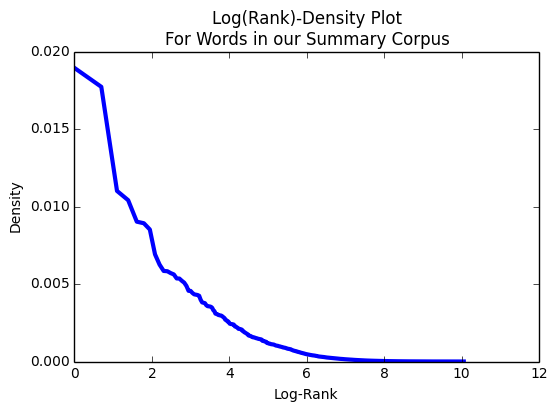

In [35]:
#then plot rank-density plot
#for the sake of easier visuals, we will log the rank
desiredLineWidth = 3
plt.plot(np.log(wordFrequencyFrame.index+1),wordFrequencyFrame["Density"],
         lw = desiredLineWidth)
plt.xlabel("Log-Rank")
plt.ylabel("Density")
plt.title("Log(Rank)-Density Plot\nFor Words in our Summary Corpus")

_Figure 5: Distribution of our words on the $\log(Rank)$ of the words._

We see that while we have around $e^{10} \approx 22000$ words in our distribution, the density peters out after the $e^6 \approx 400$ most frequent words. This suggests that we have many words that occur extremely rarely in our dataset and only a few words that occur relatively often. This is referred to as a distribution that behaves as a **Zipfian distribution**, which is a type of distribution where you have a few events that occur very often and many events that occur rarely. This distribution is fundamental to understanding the language-generating process within NLP.

Let us see what are top $10$ most frequent words are. We will import some visualization features to embed a table within our Jupyter notebook.

In [36]:
#grab top ten words
topLev = 10
topTenWordFrame = wordFrequencyFrame.iloc[0:topLev,:].loc[:,
                                                        ["Word","Frequency"]]
#then display
from IPython.display import display, HTML
display(HTML(topTenWordFrame.to_html(index = False)))

Word,Frequency
love,46967
like,43942
life,27290
people,25806
new,22369
time,22116
good,21116
enjoy,17146
get,15498
looking,14487


_Table 1: Our top ten most frequent words by their count frequency._

We see that words that display some level affection are emphasized, such as "like" and "love." Words with positive connotations also seem to occur often, as shown by the frequency of "good" and "enjoy." There is also a sense of discovery of new individuals that pervades our vocabulary, as shown by the occurence words such as "looking", "new", and "people."

<a id="languageModels" />

## Language Models

Before we begin trying to predict the age of a writer, we must first introduce the way we use language in the prediction process. **Features** are the components of your data you use to predict your **outcome** variable. In this context, our features are the language, and our outcome is age. However, how do I go about encoding language as a feature? This is the fundamental question of **feature engineering**.

In NLP, feature engineering often boils down to a way of representing each document in a corpus as some numerical vector. This numerical vector is referred to as the **encoding** of a document. Some would argue that encoding is purely for practical purposes, and would argue that an encoding of a document is arbitrary. However, NLP practitioners have shown how encodings place important assumptions on how a document was generated. The way we represent a document-generating process is referred to as **language modeling**.

Language modeling could be a lecture unto itself (which may be a good potential followup). However, for the time being, we will describe one of the most simple models of language generation: the **unigram**.

let us describe a document of lenght $n$ as a sequence of words

$$W = (w_1,w_2,...,w_n).$$

A simple way to describe how this document is generated is through some form of distribution over the words that exist in the document. The unigram model assumes that every word in the sequence is generated **independently of the words before it and the words after it**. For example, consider the second word that occurs in the sequence $w_2$. What we are stating is that the probability of seeing $w_2$ occur in the document is independent of whatever other words I see in this document. Mathematically,

$$P(w_2 | w_1,w_3,...,w_n) = P(w_2)$$

This essentially leads to the implication that the probability of seeing a document is equal to the product of the likelihood of each word occuring in this document:

$$P(W) = P(w_1,w_2,...,w_n) = P(w_1)P(w_2)...P(w_n) = \prod_{i = 1}^n P(w_i).$$

In this extent, the sufficient information we need to know to explain how a document is generated is just a **probability distribution over all words in our vocabulary**.

Let us simulate how this model generates language. We will take our current word distribution (see [Summary Statistics](#summaryStatistics)) and simulate a process of pulling our language from a hat containing that distribution. This is why this language model is referred to commonly as a **bag of words**.

In [37]:
#build bag of words distribution
bow = []
for word in filteredWordCounter:
    #make observation list by multiplying by count
    wordObsList = [word] * filteredWordCounter[word]
    #then extend bow as such
    bow.extend(wordObsList)
#print bow

In [38]:
#build sampling function
import random #for sampling
def generateLanguage(numWords,bow):
    #helper that generates our language using out bag of words
    newPhraseList = []
    for i in xrange(numWords):
        #sample a word from our distribution
        newWordList = random.sample(bow,1)
        newPhraseList.extend(newWordList)
    newPhrase = " ".join(newPhraseList)
    return newPhrase

In [39]:
#some examples
sentenceLenList = [2,4,8,16]
for sentenceLen in sentenceLenList:
    print generateLanguage(sentenceLen,bow)

eastern assets
easy find see partner
lot fancy little much funny engage important baking
towards together humor instead new night kindness every wisely short towards anyone totally pro something working


According to our language model, these are dating profiles that can be generated. However, do these represent realistic forms of communication? Do these look like realistic self-summaries for dating profiles? It is apparent that the answer is no. This is an extremely unrealistic model for how our langauge is generated, most notably because each word is generated independently of each other in the document. Given the many phrasal dependencies that occur in real documents, this is not a realistic assumption to make. That being said, we will see how using this model of language actually performs reasonably well for the task of prediction.

Given that we use a unigram model of language, the only information I need to know to inform a documents likelihood of generation, i.e. $P(W),$ is simply the frequencies of the words that appear in the document. Thus, This leads to a bag of words encoding that maps each document $W$ to an encoding $D_{W}.$ The encoding $D_{W}$ is a vector of length $|V|$, where $V$ is the vocabulary of our corpus. If we define an ordering of words over our vocabulary, we can say that the $i$th component of $D_{W}$ is

$$D_{W,i} = \text{number of times word }i\text{ appears in document }W.$$

This defines the way we will encode the documents in our corpus.

## Prediction with Language

One of the essential reasons why NLP is significant in data science is that language has often been shown to be an effective predictor of structural and environmental components in the world. In our case, we might be interested in seeing how language of a writer can help us predict the age of the writer. Let us first take a look at the distribution of ages available in this dataset.

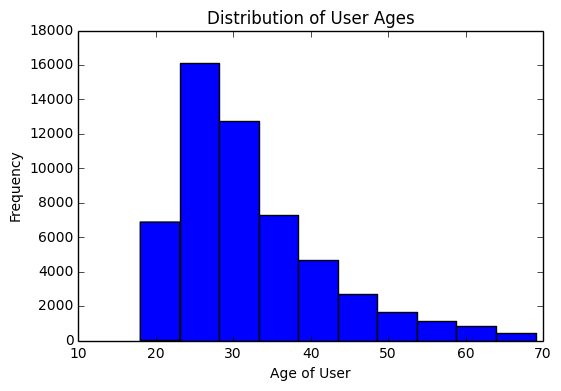

In [40]:
#mkae a histogram
newPlot = plt.hist(filteredOkCupidFrame["age"])
plt.xlabel("Age of User")
plt.ylabel("Frequency")
plt.title("Distribution of User Ages")

_Figure 6: Distribution of the ages of users in this dataset._

We see that there is a large concentration of users in the $[20,30]$ age range and a slight tail of users extending into older ages. This is expected due to the fact that OkCupid specifically targets young adults for its main user base.

We are interested in seeing if we can use the language content in the summary of a user to predict some measurement of age. For the sake of simplification, let us try to predict whether someone is within the millenial age range. For a beginner's prediction problem, it is much easier to deal with predicting a binary outcome than a continous scale of outcomes. For the sake of further simplification, we will assume that a millenial is anyone under of $28.$

In [41]:
#generate the variable from our stated cutoff
filteredOkCupidFrame["isMillenial"] = 0
millenialCutoff = 28
filteredOkCupidFrame.loc[filteredOkCupidFrame["age"] < millenialCutoff,
                         "isMillenial"] = 1

The typical **supervised learning** task is initialized as such:

Given a target variable $Y$ and a feature set $X$, We are looking for a function $f$ such that

$$f : X \rightarrow Y.$$

In the task of **regression**, $Y$ is some continuous set of variables (typically $\mathbb{R}$). In the task of **classification**, $Y$ is some discrete set of variables. In our case, $Y = \{0,1\},$ where $1$ represents the instance where someone is a millenial and $0$ represents the instance where someone is not a millenial. This would be considered a **binary classification** task.

For this task, we will introduce a model (or, to some degree, a family of functions) referred to as **logistic regression**. Say that we are interested in estimating the probability that one is a millenial given our feature set, i.e.

$$P(isMillenial|X).$$

Logistic regression assumes that this function takes on a **sigmoidal** form:

$$P(isMillenial|X) = \frac{1}{1 + e^{-r(X)}},$$

where $r : X \rightarrow \mathbb{R}$ is some regression function. This function $r$ is the main reason why logistic regression is referred to as regression despite being used for classification purposes.

Our model takes an additional assumption: that $r$ is a function that is linear in our feature set. Take $X_i$ to be the frequency of word $i$ in our document, $i \in V.$ We see that

$$r(X) = \sum_{i = 1}^{|V|} \beta_i X_i,$$

where $\beta_i$ is some weight, $i \in V.$ The main question that we want to know is, what are the optimal $\beta_i$'s to fit this model?

We won't have enough time to discuss the training algorithm used to find our weights for $r$, but for the time being, we will say that we will train this logistic regression with an objective function featuring an $L_1$ penalty. An **objective function** is some function that we either minimize or maximize in a way to find our weights. In that sense, the objective function is some measurement as to **how well our model is performing relative to other models**. We would prefer this objective function to be one that measures **how well our model is fitting the data**. The $L_1$ penalty is a component of the objective function that penalizes models that place to large of weights. To some degree, this allows our objective function to prefer models that fit the data well, but penalize models that are overly complex and assign too many weights to too many features. The $L_1$ penalty is useful **when our feature set is very large.**

We will use Scikit-learn ```sklearn``` to build the bag-of-words representation of our summaries discussed in the [previous section](#languageModels). We will then use a Logistic Regression with $L_1$ penalty for our predictive pipeline.

In [42]:
#import our count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
#make a vocab dictionary
counterList = filteredWordCounter.most_common()
vocabDict = {}
for i in xrange(len(counterList)):
    rankWord = counterList[i][0]
    vocabDict[rankWord] = i
#initialize vectorizer
vectorizer = CountVectorizer(min_df=1,stop_words=stopWordSet,
                             vocabulary = vocabDict)
#then fit and transform our summaries
bagOfWordsMatrix = vectorizer.fit_transform(filteredOkCupidFrame["essay0"])
#print bagOfWordsMatrix

In [43]:
#get language frame
langFrame = pd.DataFrame(bagOfWordsMatrix.toarray(),
                         columns = vectorizer.get_feature_names())
#display(langFrame)

In [44]:
#import linear model
import sklearn.linear_model as lm
#build model
initialLinearMod = lm.LogisticRegression(penalty = "l1")
initialLinearMod.fit(langFrame,filteredOkCupidFrame["isMillenial"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now that we have fit our model, let us see how well we are currently fitting our dataset. We will first test for accuracy of our model on the decision rule that if our predicted probability is above $.5$, we will predict that an individual is a millenial.

In [45]:
#make predictions
predictionVec = initialLinearMod.predict(langFrame)
filteredOkCupidFrame["predictedLabel"] = list(predictionVec)
#print filteredOkCupidFrame["predictedLabel"]

In [46]:
#then test for accuracy
accurateFrame = filteredOkCupidFrame[filteredOkCupidFrame["isMillenial"] ==
                                     filteredOkCupidFrame["predictedLabel"]]
accuracy = float(accurateFrame.shape[0]) / filteredOkCupidFrame.shape[0]
print accuracy

0.789867978921


We see that our model is predicting accurately around $78.99\% \approx 80\%$ of the time on our current dataset. This means that on the dataset it is using to **train**, it makes a predictive mistake on average about $1$ for every $5$ predictions. Depending on the context, this might not be an ideal fit for the data. That being said, given that this is an accuracy rate built on a relatively naïve feature set (see [Language Modeling](#languageModels)), we are performing surprisingly well despite rather simple methods that we are using.

Let us now look at the **confusion matrix** of our predictions. A confusion matrix is a matrix that compares our predicted outcomes on our actual labels. In particular, row $i$ indicates instances where our model predicts label $i$, and column $j$ indicates instances where our model predicts label $j$. When put together, Cell $i,j$ of the confusion matrix contains the number of observations where we predict label $i$ on outcomes that are actually labeled $j$.

In [47]:
#confusion matrix
confusionMat = pd.DataFrame({0:[0,0],1:[0,0]})
#get our indices
rowIndices = list(confusionMat.index)
colIndices = list(confusionMat.columns)
#then run through theses
for row in rowIndices:
    for col in colIndices:
        #grab observations with row predictedLabel and col actual label
        givenObs = filteredOkCupidFrame[
                (filteredOkCupidFrame["predictedLabel"] == row) &
                (filteredOkCupidFrame["isMillenial"] == col)]
        #then just get the number of observations in this situation
        numObs = givenObs.shape[0]
        #then store is
        confusionMat.loc[row,col] = numObs
#then display our confusion matrix
display(confusionMat)

,0,1
0,30821,7531
1,3913,12196


We see that we have about $7526$ observations that we predicted as not millenials (label $0$), but were actually millenials (label $1$). This is referred to as **false negatives** in a binary classification problem. We also see that we have about $3912$ observations that we predicted as millenials (label $1$), but were actually non-millenials (label $0$). This is referred to as **false positives** in a binary classification problem. In this context, we see that our false negative rate is slightly larger than our false positive rate in magnitude, but it is very important to note that this is a large portion of the millenials we are predicting incorrectly upon (about $\frac{7526}{7526 + 12201} \cdot 100 \approx 38\%$). To some degree, it's important to note that we have way fewer millenials in this dataset by our labeling hypothesis than non-millenials. This leads to what we call an **imbalanced classes** problem in binary classification. We will discuss more about the potential impact of this issue in our [Next Questions](#nextQuestions) section.

Let us take a look at the coefficients fit for our model.

In [48]:
#look at coefficients
coefVec = initialLinearMod.coef_[0] #because logistic regression syntax
coefFrame = pd.DataFrame({"Feature Name": vectorizer.get_feature_names(),
                         "Coefficient":coefVec})
#get number of 0 coefficients
zeroCoefFrame = coefFrame[coefFrame["Coefficient"] == 0]
numZeroCoeffs = zeroCoefFrame.shape[0]
print "The number of betas that equal 0 are", numZeroCoeffs

The number of betas that equal 0 are 16673


When we compare this to the fact there are $\approx 22000$ words in our corpus, we see that approximately $76\%$ of the words we considered in this initial model have no predictive effect in our current fitted model. Thus, this is an extremely sparse model in terms of our coefficients, which shows the strength of the $L_1$ penalty. It is also important to tie this back to the original sparsity in our word distribution. Since the $400$ most frequent words take up most of our word distribution, we have many words that occur so rarely that they do not have any predictive effect.

Let us look at our non-zero coefficients. For the time we have, we will interpret the coefficients with the largest magnitude.

In [49]:
#consider nonzero coefficients
nonZeroCoeffFrame = coefFrame[coefFrame["Coefficient"] != 0]
#get absolute magnitude of coefficients
nonZeroCoeffFrame["absCoeff"] = np.abs(nonZeroCoeffFrame["Coefficient"])
#order by absolute value
nonZeroCoeffFrame = nonZeroCoeffFrame.sort_values("absCoeff",
                                                  ascending = False)
#then display values
#display(HTML(nonZeroCoeffFrame.to_html(index = False)))

To interpret the meaning of these coefficients, let us look back at the mathematical representation of the model we fit:

$$P(isMillenial | X) = \frac{1}{1 + e^{-\sum_{i = 1}^{|V|} \beta_i X_i}}.$$

We see that if our coefficient for word $i$ ($\beta_i$) is positive, this makes our denominator smaller and pushes our prediction closer to the $isMillenial$ direction. Similarly, if the coefficient is negative, this will make our denominator bigger and push our predictions away from the $isMillenial$ direction.

We see that "pregnancy" seems to be a word that has the highest magnitude in its coefficient, which suggests that pregnancy seems to be an important indicator for whether the profile writer is a millenial. This is a bit peculiar, given that pregnancy seems to be something that is uninteresting to younger millenials who tend to not be interested in "settling down" any time soon. That being said, we see that "unyielding" and "unsatisfied" seem to also be strong indicators of whether a writer is a millenial or not. To some degree, this paints an interesting narrative: that millenials can often look at relationships as a new experience, something where they can have "unyielding" discover of themselves compared to a lack of satisfaciton in previous relationships. This would then beg the question as to whether these are also focuses for non-millenials.

That being said, it is often useful to look at a set of example predictions to see how flexible our model might be in other dating contexts. Let's take a look at one profile we accurately predict is a millenial.

In [50]:
millenialProfileInd = 17 #checked this earlier
print "The age of this profile is :", filteredOkCupidFrame.loc[millenialProfileInd,"age"]
print "Their Self-Summary:"
print
givenEssay = filteredOkCupidFrame.loc[millenialProfileInd,"essay0"]
print givenEssay
#make our predictions
newBOW = vectorizer.transform([givenEssay])
newPrediction = initialLinearMod.predict(newBOW)
print
if (newPrediction[0] == 1):
    print "Our Model Predicts this person is a millenial"
else:
    print "Our Model Predicts this person is not a millenial"

The age of this profile is : 26
Their Self-Summary:

to sum myself in whole: i have adventurous tendencies with a
somewhat vulgar flare (i hope you can take a joke-offensive or
not).<br />
<br />
i'm a constant seeker of discovering something new, whether it be a
different restaurant, culture, or music (anything really). i tend
to have an eclectic personality.<br />
<br />
i volunteer and participate with a lot of activities with my
community. i also tend to seek those who have a story, any story.
i'm all ears! i want to learn from you, hear what you have to say,
and relate it to my own personal experience.<br />
<br />
i'm a bit of a nerd and like to watch the history, military, and
discovery channel. something about militaristic strategies intrigue
me.<br />
<br />
i'm a bit of a tom boy, so i indulge in shooting guns, playing
video games, and working out consistently. i also have the guilty
pleasure of watching ridiculous comedy (family guy, curb your
enthusiasm, it's always sunny .

We see that our model predicts this person is a millenial, and when we look at the contents of the summary, it is not extremely surprising. We see that this individual enjoys video games (a trope of millenials), and discusses a lot about their nerd-oriented hobbies.

However, let us see how our model performs in a different context. Let's take a look at my old Tinder bio. 

In [51]:
#try my Tinder profile
michaelTinderSummary = """Senior at Carnegie Mellon, starting work in Boston
next summer as a data scientist at place X :D

I enjoy books, singing, coffee, and polar bears :D"""
#lower it
michaelTinderSummary = michaelTinderSummary.lower()
#then predict
personalBOW = vectorizer.transform([michaelTinderSummary])
personalPrediction = initialLinearMod.predict(personalBOW)
print personalPrediction

[0]


Interestingly, this summary makes an innaccurate prediction, since I am $21$ and yet it suggests that I am not a Millenial. That being said, given the many emoticons and proper nouns featured in my profile, it is likely that there are many words that were not picked up in the features since they were not in the **original vocabulary**.

Let us take a look at another individual's Tinder profile.

In [52]:
#try a friend's Tinder profile
friendTinderSummary = """Insert a friend's profile here"""
#lower it
friendTinderSummary = friendTinderSummary.lower()
#then predict
friendBOW = vectorizer.transform([friendTinderSummary])
friendPrediction = initialLinearMod.predict(friendBOW)
print friendPrediction

[0]


We see that even for my millenial friend, we are still predicting that they are not a millenial! There are a couple components to this that we need to consider:

* Our model is rather inflexible to new words. We still do not have a way of encoding words that are out of our vocabulary, and that can severely affect predictions like on my Tinder profile.

* Our model is rather inflexible to context. The nature of what individuals write on their profiles on [OkCupid](https://www.okcupid.com) can be very different than what individuals write on a [Tinder](https://www.gotinder.com) profile. To this extent, it might be important for us to consider how our model might be effective on out-of-corpus situations.

<a id="nextQuestions" />

## Next Questions

Let us recap what we have done in this workshop.

* We figured out a way of ingesting and cleansing using the ```pandas``` package and the regular expression framework of pattern recognition within text.

* We used a set of language processing tools to develop summary statistics on the words found at the document level and the corpus level.

* We then walked through a method of how we can encode our language to be a set of numerical features in a **prediction pipeline**, a structure that takes in a set of inputs (or features) and gives us a set of predictive outputs.

* We then used this encoding to predict the age of the writer of said documents using logistic regression.

There are a couple of questions we may be left with when we finish this process.

* Our model of language is rather unrealistic, but it seems to give us a feature set that predicts Millenialism very well. Some would argue, does the model of language truly matter? I would argue that it actually does. In particular, if we want to make stronger inferential statements about how our language informs a particular outcome variable, we need to have a deeper representation of how our language is encoded beyond word frequencies.

* The logistic regression model is only one way of modeling the probability of a binary outcome. Why do we choose just a sigmoidal structure? What if the true conditional probability distribution of $isMillenial$ is given our features ($X$) is slightly different? These become questions that **statistical modeling** and **machine learning** are concerned with.

* What is the impact of an imbalanced classes problem on the binary classification task?

* How might I be able to incorporate out-of-vocabulary features in my language into my current model?

* How might I make my model more flexible to documents and contexts outside of OkCupid Profiles? Is this a worthwhile goal to achieve?

For some of these questions, I recommend looking into some of the [Reference Materials](#refMaterials) that I would list below. There are many potential applications of using language data, and today we only worked on a rather simple one. Hopefully, I have given you a decent start on finding ways to manipulate language data on your own. Thank you!

<a id="refMaterials" />

## Reference Materials